##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. You will gain practical experience with the following concepts:

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:

import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = 'DB/mask_nomask'
data_dir = pathlib.Path(data_dir)

In [4]:
data_dir

PosixPath('DB/mask_nomask')

After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3762


Here are some roses:

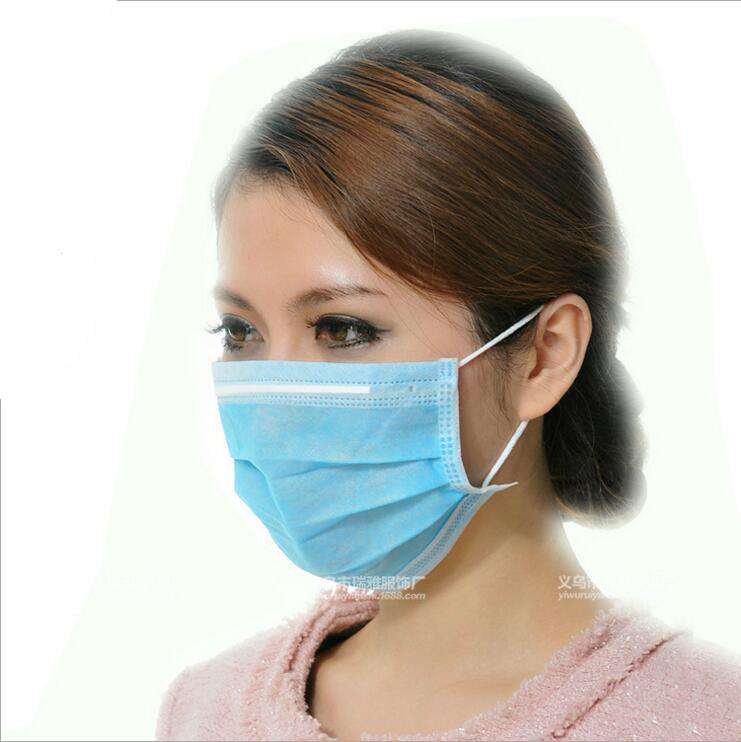

In [6]:
roses = list(data_dir.glob('mask/*'))
PIL.Image.open(str(roses[0]))

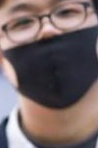

In [7]:
PIL.Image.open(str(roses[1]))

And some tulips:

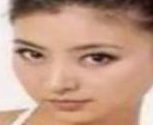

In [8]:
tulips = list(data_dir.glob('nomask/*'))
PIL.Image.open(str(tulips[0]))

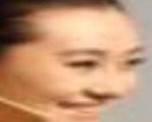

In [9]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 128
img_width = 128

It's good practice to use a validation split when developing your model. Let's use 80% of the images for training, and 20% for validation.

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4092 files belonging to 2 classes.
Using 3274 files for training.


In [12]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4092 files belonging to 2 classes.
Using 818 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['mask', 'nomask']


## Visualize the data

Here are the first 9 images from the training dataset.

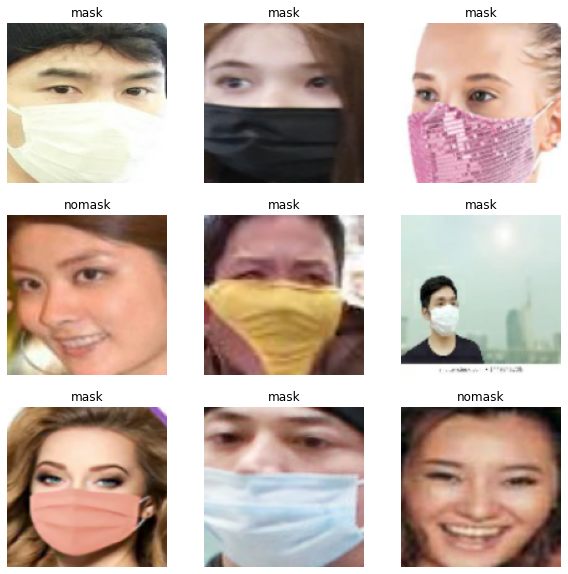

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, you will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

Note: The Keras Preprocessing utilities and layers introduced in this section are currently experimental and may change.

There are two ways to use this layer. You can apply it to the dataset by calling map:

Or, you can include the layer inside your model definition, which can simplify deployment. Let's use the second approach here.

Note: you previously resized images using the `image_size` argument of `image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. This model has not been tuned for high accuracy, the goal of this tutorial is to show a standard approach. 

In [38]:
if 0:
    # keras imports
    import tensorflow as tf
    from tensorflow.keras.applications import MobileNetV2
    from tensorflow.keras.models import Model, load_model
    from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.optimizers import SGD
    from tensorflow.keras.callbacks import ModelCheckpoint

    # other imports
    import json
    import datetime
    import time
    def get_mobilenetv2():
        base_model = MobileNetV2(include_top=False, weights='imagenet', 
                                input_tensor=Input(shape=(224,224,3)), input_shape=(224,224,3))
        top_layers = base_model.output
        top_layers = GlobalAveragePooling2D()(top_layers)
        top_layers = Dropout(.2)(top_layers)
        top_layers = Dense(128, activation='relu')(top_layers)
        predictions = Dense(2, activation='softmax')(top_layers)
        model = Model(inputs=base_model.input, outputs=predictions)
        return model

In [56]:

def get_simplecnn():
    num_classes = 2
    model = Sequential([
      layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])
    return model

def get_model():
    return get_simplecnn()
    #return get_mobilenetv2()
model = get_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)       

## Compile the model

For this tutorial, choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument.

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model

In [58]:
#model.load_weights('model.h5')

In [59]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
103/103 [==============================] - 1s 12ms/step - loss: 0.5071 - accuracy: 0.7498 - val_loss: 0.4415 - val_accuracy: 0.8068
Epoch 2/10
103/103 [==============================] - 1s 10ms/step - loss: 0.2813 - accuracy: 0.8919 - val_loss: 0.2559 - val_accuracy: 0.8985
Epoch 3/10
103/103 [==============================] - 1s 11ms/step - loss: 0.2139 - accuracy: 0.9191 - val_loss: 0.2124 - val_accuracy: 0.9230
Epoch 4/10
103/103 [==============================] - 1s 11ms/step - loss: 0.1848 - accuracy: 0.9301 - val_loss: 0.1817 - val_accuracy: 0.9438
Epoch 5/10
103/103 [==============================] - 1s 11ms/step - loss: 0.1443 - accuracy: 0.9465 - val_loss: 0.1504 - val_accuracy: 0.9584
Epoch 6/10
103/103 [==============================] - 1s 11ms/step - loss: 0.1146 - accuracy: 0.9578 - val_loss: 0.1534 - val_accuracy: 0.9523
Epoch 7/10
103/103 [==============================] - 1s 11ms/step - loss: 0.0813 - accuracy: 0.9685 - val_loss: 0.1726 - val_accuracy: 0.9328

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

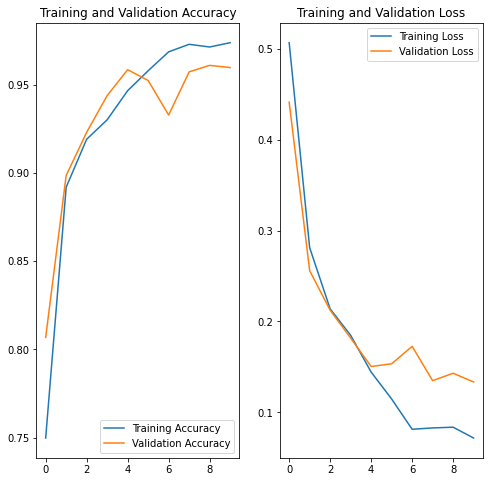

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

Let's look at what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *Dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside your model like other layers, and run on the GPU.

In [61]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

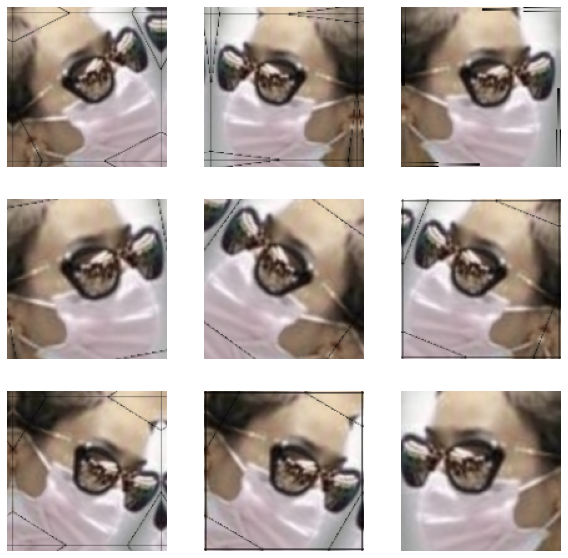

In [62]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

In [63]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0361 - accuracy: 0.9866 - val_loss: 0.1988 - val_accuracy: 0.9462
Epoch 2/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0476 - accuracy: 0.9811 - val_loss: 0.1703 - val_accuracy: 0.9523
Epoch 3/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0417 - accuracy: 0.9869 - val_loss: 0.1358 - val_accuracy: 0.9621
Epoch 4/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0340 - accuracy: 0.9890 - val_loss: 0.1649 - val_accuracy: 0.9548
Epoch 5/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0432 - accuracy: 0.9838 - val_loss: 0.2480 - val_accuracy: 0.9181
Epoch 6/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.1368 - val_accuracy: 0.9682
Epoch 7/15
103/103 [==============================] - 1s 11ms/step - loss: 0.0268 - accuracy: 0.9905 - val_loss: 0.2057 - val_accuracy: 0.9523

In [64]:
model.evaluate(val_ds)

26/26 [==============================] - 0s 4ms/step - loss: 0.2067 - accuracy: 0.9609


[0.20667432248592377, 0.9608802199363708]

In [65]:
model.save('model.h5')

In [66]:
#model=tf.keras.models.load_model('model.h5')

## Visualize training results

After applying data augmentation and Dropout, there is less overfitting than before, and training and validation accuracy are closer aligned. 

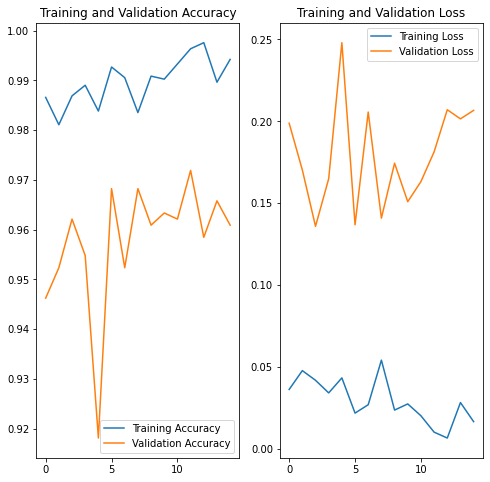

In [67]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [71]:
#sunflower_url = 'https://www.iconspng.com/images/tom-cruise-face-close-up.jpg'
#sunflower_url = 'https://media.glamour.com/photos/5a425fd3b6bcee68da9f86f8/16:9/w_2560%2Cc_limit/best-face-oil.png'
sunflower_path = '/home/skycam/sample_projs/Mask/mask_app/classifier/DB/mask_nomask/nomask/0_0_chenxiang_0006.jpg'
#sunflower_path = '/home/skycam/sample_projs/Mask/mask_app/classifier/DB/mask_nomask/mask/0_0_0 copy 4.jpg'


img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print( score)
th=.5
if score[0].numpy()[0]>th:
    print('Image most likely a mask')
else:
    print('Image most likely a violation')



tf.Tensor([[3.6216754e-06 9.9999642e-01]], shape=(1, 2), dtype=float32)
Image most likely a violation


In [54]:
score[0].numpy()[0]

0.5413703

In [72]:
model2=tf.keras.models.load_model('model.h5')

In [73]:
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions)

print( score)
th=.5
if score[0].numpy()[0]>th:
    print('Image most likely a mask')
else:
    print('Image most likely a violation')

tf.Tensor([[3.6216754e-06 9.9999642e-01]], shape=(1, 2), dtype=float32)
Image most likely a violation
